In [1]:
from cgmm_mvdr import OnlineCGMMMVDR

In [2]:
import soundfile as sf
import numpy as np
from scipy.signal import stft, istft
import matplotlib.pyplot as plt
import IPython.display as dsp

## Estimation of a-priori expectation of SCM

Here, as an example, we simply estimate the prior from one recording that has similar spatial positions of microphone array, target and noise.

In [3]:
s_tgt, fs = sf.read('test_audios/mixture2_target.wav')
s_noise, fs = sf.read('test_audios/mixture2_noise.wav')

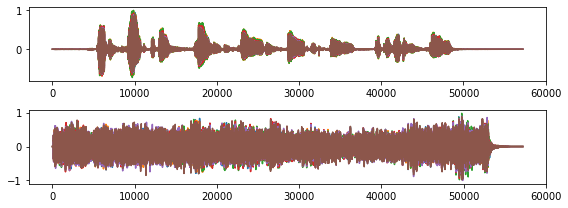

In [4]:
fig,ax = plt.subplots(2, figsize=(8,3))
ax[0].plot(s_tgt)
ax[1].plot(s_noise)
plt.tight_layout()
plt.show()

In [5]:
dsp.display(dsp.Audio(s_tgt[:,0], rate=fs))
dsp.display(dsp.Audio(s_noise[:,0], rate=fs))

In [6]:
stft_opts = {
    'nperseg': 200, 'noverlap': 100, 'nfft': 200
}

In [7]:
_,_,spec_tgt = stft(s_tgt.T, **stft_opts)
_,_,spec_noise = stft(s_noise.T, **stft_opts)

In [8]:
R_tgt_prior = np.einsum('cft,dft->fcd', 
                  spec_tgt, spec_tgt.conj()) / spec_tgt.shape[-1]
R_noise_prior = np.einsum('cft,dft->fcd', 
                  spec_noise, spec_noise.conj()) / spec_noise.shape[-1]

## Running CGMM-MVDR

In [9]:
s, fs = sf.read('test_audios/mixture1.wav')

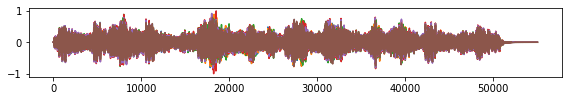

In [10]:
plt.figure(figsize=(8,1.5))
plt.plot(s)
plt.tight_layout()
plt.show()

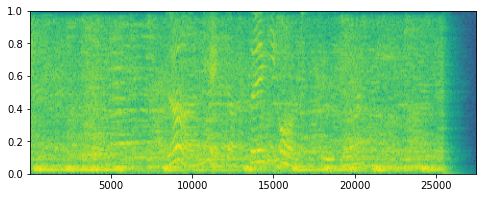

In [11]:
plt.figure(figsize=(8,3))
plt.specgram(s[:,0])
plt.show()

In [12]:
dsp.display(dsp.Audio(s[:,0], rate=fs))

In [13]:
_,_,spec = stft(s.T, **stft_opts)

In [14]:
cgmm_mvdr = OnlineCGMMMVDR(
    ny_k=10, ny_n=10, priorRk=R_tgt_prior, priorRn=R_noise_prior,
    channels=spec.shape[0], frequency_bins=spec.shape[1],
    beg_noise=160, # about 2 seconds,
    end_noise=80, # about 1 second
)

In [15]:
spec_enh = []
mask = []

for i in range(spec.shape[-1]):
    spec_enh1, mask1 = cgmm_mvdr.step(spec[:,:,i], i, spec.shape[-1])  
    spec_enh.append(spec_enh1)
    mask.append(mask1)
    
spec_enh = np.stack(spec_enh).transpose(1,0,2)
mask = np.stack(mask)

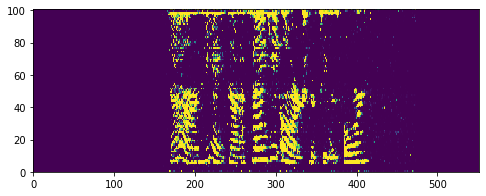

In [16]:
plt.figure(figsize=(8,3))
plt.pcolormesh(mask.T)
plt.show()

In [17]:
_,s_enh1 = istft(spec_enh[0].T, **stft_opts)
_,s_enh2 = istft(spec_enh[1].T, **stft_opts)

In [18]:
dsp.display(dsp.Audio(s_enh1, rate=fs))
dsp.display(dsp.Audio(s_enh2, rate=fs))